<a href="https://colab.research.google.com/github/AshwinDeshpande96/LANL-Earthquake-Prediction/blob/master/LANL_Earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Raw Data Fetching

In [0]:
#Get 'kaggle.json' file from your kaggle profile. Click on 'Edit Profile' --> 'Create New API Token'
#Upload 'kaggle.json' file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{u'kaggle.json': '{"username":"ashwinkd","key":"cf4cc5f8bbcdfbf14e3dc8e256413eb4"}'}

In [0]:
#Make /root/.kaggle/ directory. So that kaggle command can download the data
!mkdir /root/.kaggle/
#Move downloaded 'kaggle.json' to previously created directory
!mv /content/kaggle.json /root/.kaggle/
#change permissions of 'kaggle.json' so that it is only accessible by you
!chmod 600 /root/.kaggle/kaggle.json
!ls /content/

sample_data


In [0]:
#download the Data given by Kaggle Competition
!kaggle competitions download -c LANL-Earthquake-Prediction
#this downloads 3 files: 
#1) sample_submisison.csv  
#2) test.zip - (this contains 2624 csv files with 150000 rows of acoustic_data)   
#3) train.csv.zip - Contains one csv file with approx 150000*4195 rows of ['acoustic_data', 'time_to_failure']
!ls

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 29.6MB/s]
 96% 233M/242M [00:03<00:00, 45.7MB/s]
100% 242M/242M [00:04<00:00, 63.0MB/s]
100% 2.02G/2.03G [00:45<00:00, 58.5MB/s]
100% 2.03G/2.03G [00:45<00:00, 48.3MB/s]
sample_data  sample_submission.csv  test.zip  train.csv.zip


In [0]:
#extract train.csv.zip file to obtain train.csv file
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


In [0]:
#extract test.zip file to obtain 2624 'seg_******.csv' files
!unzip test.zip
!ls

In [0]:
#raw data sample
raw_sample = pd.read_csv('train.csv', nrows=100)
raw_sample.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


# Feature Extraction

In [0]:
#Link up to Google Drive to store Extracted Feature Data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from sklearn.linear_model import LinearRegression
#this function returns a single feature: 'abs_trend'
def add_trend_feature(arr, abs_values=False):
    """Fit a univariate linear regression and return the coefficient."""
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]


In [0]:
#this function creates a row  124 features
import numpy as np
def extract_features_from_segment(x):
    """Returns a dictionary with the features for the given segment of acoustic data."""
    features = {}
    
    features['ave'] = x.values.mean()
    features['std'] = x.values.std()
    features['max'] = x.values.max()
    features['min'] = x.values.min()
    #features['med'] = np.median(x.values)
    #features['last'] = x.values[-1]
    features['q90'] = np.quantile(x.values, 0.90)
    features['q95'] = np.quantile(x.values, 0.95)
    features['q99'] = np.quantile(x.values, 0.99)
    features['q05'] = np.quantile(x.values, 0.05)
    features['q10'] = np.quantile(x.values, 0.10)
    features['q01'] = np.quantile(x.values, 0.01)
    features['std_to_mean'] = features['std'] / features['ave']
    
    features['abs_max'] = np.abs(x.values).max()
    features['abs_mean'] = np.abs(x.values).mean()
    features['abs_std'] = np.abs(x.values).std()
    features['trend'] = add_trend_feature(x.values)
    features['abs_trend'] = add_trend_feature(x.values, abs_values=True)
    
    # New features - rolling features
    for w in [10, 50, 100, 1000]:
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_min = x.rolling(w).min().dropna().values
        x_roll_max = x.rolling(w).max().dropna().values
        
        features['ave_roll_std_' + str(w)] = x_roll_std.mean()
        features['std_roll_std_' + str(w)] = x_roll_std.std()
        features['max_roll_std_' + str(w)] = x_roll_std.max()
        features['min_roll_std_' + str(w)] = x_roll_std.min()
        features['q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        features['q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        features['q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        features['q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        features['q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        
        features['ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        features['std_roll_mean_' + str(w)] = x_roll_mean.std()
        features['max_roll_mean_' + str(w)] = x_roll_mean.max()
        features['min_roll_mean_' + str(w)] = x_roll_mean.min()
        features['q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        features['q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        
        features['ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        features['std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        features['q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        features['q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        
        features['std_roll_min_' + str(w)] = x_roll_min.std()
        features['max_roll_min_' + str(w)] = x_roll_min.max()
        features['q05_roll_min_' + str(w)] = np.quantile(x_roll_min, 0.05)
        features['q95_roll_min_' + str(w)] = np.quantile(x_roll_min, 0.95)

        features['std_roll_max_' + str(w)] = x_roll_max.std()
        features['min_roll_max_' + str(w)] = x_roll_max.min()
        features['q05_roll_max_' + str(w)] = np.quantile(x_roll_max, 0.05)
        features['q95_roll_max_' + str(w)] = np.quantile(x_roll_max, 0.95)
    return features

In [0]:
import pandas as pd
import time as t
import os
#Feature Extraction found at https://www.kaggle.com/jsaguiar/baseline-with-multiple-models
#make_train function returns a 3 things:
#!) X_train - Training Set of shape (4195 * 124) - Each of 4195 rows is contructed by calling 'extract_features_from_segment' function from 150,000 data-chunk of train.csv file
#2) target - target variable is the value of every 150,000th  train.csv's ['time_to_failure'] data
#3) quake - not used in this project
def make_train():
    features_list = []
    target_list = []
    quake_num = []
    quake_count = 0
    row = 1
    time_so_far = 0
    for segment in pd.read_csv('/content/train.csv', chunksize=150000):
        
        start = t.time()
        
        target_list.append(segment['time_to_failure'].values[-1])
        features_list.append(extract_features_from_segment(segment['acoustic_data']))
        quake_num.append(quake_count)
        
        if any(segment['time_to_failure'].diff() > 5):
            quake_count = quake_count + 1
        
        end = t.time()
        
        time_taken = end - start
        time_so_far += time_taken
        
        print "\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b", row, "/4195 \n ETA: ", round(time_so_far/60, 1), "/", int(time_taken*4195/60) 
        
        row = row + 1
    return pd.DataFrame(features_list), pd.Series(target_list), pd.Series(quake_num)
#reads each 2624 'seg_******.csv' file and creates a (2624*124) dataset for testing
def make_test():
    features_list = {}
    
    row = 1
    time_so_far = 0
    test_files = [file for file in os.listdir(os.getcwd()) if file.startswith("seg")]          #returns an array of every seg_******.csv file in current directory
    num_test_file - len(test_files)
    for file in test_files:
        segment = pd.read_csv(file)
        start = t.time()
        
        
        features_list.append(extract_features_from_segment(segment['acoustic_data']))
        
        
        end = t.time()
        
        time_taken = end - start
        time_so_far += time_taken
        
        print "\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b\b", row, "\b/" +num_test_file+"\nETA: ", round(time_so_far/60, 1), "\b/", int(time_taken*num_test_file/60) 
        
        row = row + 1
    return pd.DataFrame(features_list)


In [0]:
#X_train, target, quake is created
X_train, target, quake = make_train()
print "Train shape:", X_train.shape, "\n", X_train.head(3), "\nTarget shape:", target.shape, "\n", target.head(3), "\nQuake shape:", quake.shape, "\n", quake.head(3), 


In [0]:
#files are saved onto Google Drive in csv format with X_train - (4195*124) rows & colums, target with (4195, 1) rows & columns, quake with (4195, 1) rows & columns
#change filepath according to your drive directory
X_train.to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/X_train.csv", index=False)
target.to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/target.csv", index=False)
quake.to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/quake.csv", index=False)

In [0]:
#test_set is created
testset = make_test()
#files are saved onto Google Drive in csv format with test_set.csv - (2624*124) rows & colums
testset.to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/test_set.csv", index=False)

Once X-train.csv, target.csv, quake.csv, test_set.csv are created we do not have to run previous cells again. 
Further program uses only the data saved in csv file in Google drive

# Data Import

In [0]:
#We start by importing previously created csv files
import pandas as pd
X = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/X_train.csv")
Y = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/target.csv")
#Uncomment if you want to use quake data
#quake = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/quake.csv")

In [0]:
#X_train.drop(X_train.tail(1).index,inplace=True)
print "Training Data:\t", X.shape
print "  Target Data:\t", Y.shape

#Display sample of training data
X.head(5)


Training Data:	(4194, 124)
  Target Data:	(4194, 1)


,abs_max,abs_mean,abs_std,abs_trend,ave,ave_roll_abs_mean_10,ave_roll_abs_mean_100,ave_roll_abs_mean_1000,ave_roll_abs_mean_50,ave_roll_mean_10,...,std_roll_min_10,std_roll_min_100,std_roll_min_1000,std_roll_min_50,std_roll_std_10,std_roll_std_100,std_roll_std_1000,std_roll_std_50,std_to_mean,trend
0,104,5.576567,4.333310,-0.000011,4.884113,5.576566,5.576655,5.579118,5.576561,4.884088,...,4.526280,6.522304,11.248606,5.787738,2.809071,3.111524,2.769772,3.176148,1.044425,-3.268300e-06
1,181,5.734167,5.732758,-0.000005,4.725767,5.734187,5.734653,5.739510,5.734444,4.725732,...,6.398675,10.162552,21.096014,8.823748,4.120785,4.893431,4.492905,4.953472,1.394229,9.090424e-07
2,140,6.152647,5.895925,0.000010,4.906393,6.152557,6.153045,6.159850,6.152678,4.906229,...,6.641086,10.535572,19.047827,9.125804,4.227960,4.959233,4.402140,5.035827,1.420060,3.962182e-06
3,199,5.933960,6.061193,-0.000002,4.902240,5.933982,5.934187,5.939037,5.933995,4.902291,...,6.695330,10.524292,20.248763,9.217610,4.284176,5.247130,4.873523,5.285204,1.412065,1.637207e-06
4,145,6.110587,6.329464,0.000005,4.908720,6.110644,6.111666,6.111178,6.111119,4.908728,...,7.153246,11.844273,20.321001,10.305776,4.183253,5.556924,5.213365,5.610383,1.487371,-6.668392e-07


In [0]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4194 entries, 0 to 4193
Columns: 124 entries, abs_max to trend
dtypes: float64(121), int64(3)
memory usage: 4.0 MB


In [0]:
X.describe()

,abs_max,abs_mean,abs_std,abs_trend,ave,ave_roll_abs_mean_10,ave_roll_abs_mean_100,ave_roll_abs_mean_1000,ave_roll_abs_mean_50,ave_roll_mean_10,...,std_roll_min_10,std_roll_min_100,std_roll_min_1000,std_roll_min_50,std_roll_std_10,std_roll_std_100,std_roll_std_1000,std_roll_std_50,std_to_mean,trend
count,4194.000000,4194.000000,4194.000000,4.194000e+03,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,...,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4.194000e+03
mean,170.075823,5.547541,5.750824,2.820684e-07,4.519464,5.547543,5.547573,5.547921,5.547557,4.519466,...,6.326125,10.153274,18.639098,8.847205,3.954092,4.717052,4.342054,4.771747,1.452519,7.541204e-09
std,296.916234,1.517176,8.340062,2.816762e-05,0.256079,1.517240,1.517853,1.524756,1.517511,0.256076,...,9.647971,17.536682,28.567386,15.156044,5.885888,8.396498,8.390481,8.335845,1.877737,1.857981e-06
min,23.000000,4.147707,2.589077,-6.957745e-04,3.596313,4.147750,4.147914,4.148826,4.147811,3.596504,...,1.816920,1.580056,2.169638,1.579772,0.805045,0.518681,0.348214,0.575145,0.575754,-8.239300e-06
25%,94.000000,5.062363,3.863091,-3.121694e-06,4.349485,5.062362,5.062362,5.061047,5.062305,4.349530,...,3.984829,5.925003,11.049593,5.225506,2.469979,2.712234,2.396497,2.765110,0.984160,-1.190444e-06
50%,127.000000,5.380957,4.781827,-2.887288e-08,4.521987,5.381057,5.381228,5.381267,5.381138,4.522241,...,5.255851,8.166803,15.161090,7.124399,3.299018,3.774899,3.367353,3.837632,1.235052,2.766691e-08
75%,175.000000,5.748583,5.888117,2.964157e-06,4.693355,5.748669,5.748843,5.748886,5.748901,4.693570,...,6.693137,10.803992,20.226106,9.396773,4.259820,5.015360,4.566104,5.087170,1.538049,1.239480e-06
max,5515.000000,32.762073,150.431867,6.645023e-04,5.391993,32.763702,32.779745,32.943215,32.770866,5.392382,...,177.335309,326.429215,536.835965,277.918474,109.412310,148.947193,148.730285,147.485651,34.866320,6.641167e-06


#  Training

In [0]:
#import required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import load_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#split the training and target data into 3/4 for training and 1/4 for validation. Choose your split with test_size= values ranging from [0,1] percentage of data
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.2, random_state=42)

 Pictorial representation of Neural Network used for Regression
![alt text](https://github.com/AshwinDeshpande96/LANL-Earthquake-Prediction/blob/master/regression%20model.jpeg?raw=true)

In [0]:
#We create a Fully Connected Dense Net Initial width 156 and Depth of 5 layers each activated by relu besides the last(output layer) as this is a regression type neural network
model = Sequential()
model.add(Dense(83 , input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(38,  kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
model.compile(loss='logcosh', optimizer=Adam(lr=1.0e-3))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
filepath = "/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/weights2.hdf5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min'),                                   #Stop training if no improvement is seen in Validation loss after 10 attempts
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min'),                    #Slow down Learning rate if Validation Loss is not Decreasing after 5 attempts
    ModelCheckpoint(filepath, save_best_only=True,  save_weights_only=False, monitor='val_loss', mode='min', verbose=1) #Best Model weights are saved in hdf5 file every epoch
]
#model = load_model('/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/model.hdf5')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=callbacks, verbose=1) #Train Model
model.save('/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/model2.hdf5')      #Save Trained model after training

Instructions for updating:
Use tf.cast instead.
Train on 3355 samples, validate on 839 samples
Epoch 1/100
3355/3355 [==============================] - 3s 825us/step - loss: 3.3460 - val_loss: 2.1489

Epoch 00001: val_loss improved from inf to 2.14890, saving model to /content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/weights2.hdf5
Epoch 2/100
3355/3355 [==============================] - 0s 56us/step - loss: 2.3242 - val_loss: 1.9146

Epoch 00002: val_loss improved from 2.14890 to 1.91464, saving model to /content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/weights2.hdf5
Epoch 3/100
3355/3355 [==============================] - 0s 56us/step - loss: 2.0791 - val_loss: 1.8416

Epoch 00003: val_loss improved from 1.91464 to 1.84162, saving model to /content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/weights2.hdf5
Epoch 4/100
3355/3355 [==============================] - 0s 56us/step - loss: 2.0012 - val_loss: 1

# Testing

In [0]:

test_files = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission.csv")['seg_id']                 #Get all Test Segments Names for printing name and it's prediction
test_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/test_set.csv")                    #Read Test Data
print test_df.values.shape

(2624, 124)


In [0]:
#model = load_model('/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/model.hdf5')                         #Load Trained Model                                                                                                   
model.load_weights(filepath)
ynew = model.predict(test_df.values)
#print len(ynew), len(test_files)
#Predict Y value('time_to_failure') for every 2624 row
submission = []                                                                                                                         #Array to save Segment and it's prediction
for i in range(len(ynew)):
    submission.append( {"seg_id":test_files[i], "time_to_failure":ynew[i][0]})                                                          #Save every segment and it's prediction in submission array
pd.DataFrame(submission).to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission2.csv", index=False) #Save Predictions in a csv file

In [0]:
import pandas as pd
submission_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission2.csv")           #Read Saved Submission File
print submission_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

       seg_id  time_to_failure
0  seg_63c8e4         9.510502
1  seg_5f352e         2.423452
2  seg_8fc754         5.478032
3  seg_f7290f         2.763848
4  seg_2383c2         4.335784


# XGBOOST

In [0]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
param = {'max_depth' : 3, 'eta' : 0.1, 'seed' : 42}
num_round = 30
bst = xgb.train(param, dtrain, num_round, [(dtest, 'test'), (dtrain, 'train')])

[0]	test-rmse:5.80889	train-rmse:5.83416
[1]	test-rmse:5.35008	train-rmse:5.37063
[2]	test-rmse:4.94664	train-rmse:4.9625
[3]	test-rmse:4.59495	train-rmse:4.60514
[4]	test-rmse:4.28953	train-rmse:4.29337
[5]	test-rmse:4.02317	train-rmse:4.02234
[6]	test-rmse:3.79559	train-rmse:3.78767
[7]	test-rmse:3.59953	train-rmse:3.58606
[8]	test-rmse:3.43107	train-rmse:3.4135
[9]	test-rmse:3.28697	train-rmse:3.26576
[10]	test-rmse:3.1631	train-rmse:3.1398
[11]	test-rmse:3.06066	train-rmse:3.03126
[12]	test-rmse:2.97502	train-rmse:2.94033
[13]	test-rmse:2.9034	train-rmse:2.86382
[14]	test-rmse:2.84594	train-rmse:2.7988
[15]	test-rmse:2.79596	train-rmse:2.7445
[16]	test-rmse:2.75602	train-rmse:2.70004
[17]	test-rmse:2.7221	train-rmse:2.66183
[18]	test-rmse:2.69313	train-rmse:2.63013
[19]	test-rmse:2.66971	train-rmse:2.60282
[20]	test-rmse:2.65154	train-rmse:2.58018
[21]	test-rmse:2.63651	train-rmse:2.55945
[22]	test-rmse:2.62306	train-rmse:2.54277
[23]	test-rmse:2.61278	train-rmse:2.52859
[24]	test-

In [0]:
from sklearn.metrics import accuracy_score
test_mat = xgb.DMatrix(test_df.values)
preds = bst.predict(test_mat)
print len(preds)

2624


In [0]:
submission_xgboost = []                                                                                                                         #Array to save Segment and it's prediction
for i in range(len(preds)):
    submission_xgboost.append( {"seg_id":test_files[i], "time_to_failure":preds[i]})                                                          #Save every segment and it's prediction in submission array
pd.DataFrame(submission_xgboost).to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission_xgboost.csv", index=False) #Save Predictions in a csv file

In [0]:
submission_xgb_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission_xgboost.csv")           #Read Saved Submission File
print submission_xgb_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

       seg_id  time_to_failure
0  seg_63c8e4         9.306780
1  seg_5f352e         3.024169
2  seg_8fc754         8.172087
3  seg_f7290f         4.258749
4  seg_2383c2         6.530031


# LightGBM

In [0]:
import lightgbm
#categorical_features = [c for c, col in enumerate(X.columns) if 'cat' in col]
#print categorical_features
#
# Train the model
#
#split the training and target data into 3/4 for training and 1/4 for validation. Choose your split with test_size= values ranging from [0,1] percentage of data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)




train_data = lightgbm.Dataset(X_train, y_train)
test_data = lightgbm.Dataset(X_test, y_test)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose':0
}

gbm = lightgbm.train(params, train_data, num_boost_round=100, valid_sets=test_data, early_stopping_rounds=10)

[1]	valid_0's l2: 12.6875
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 12.0876
[3]	valid_0's l2: 11.5605
[4]	valid_0's l2: 11.0693
[5]	valid_0's l2: 10.6412
[6]	valid_0's l2: 10.2329
[7]	valid_0's l2: 9.88555
[8]	valid_0's l2: 9.55497
[9]	valid_0's l2: 9.25493
[10]	valid_0's l2: 8.98851
[11]	valid_0's l2: 8.73987
[12]	valid_0's l2: 8.53301
[13]	valid_0's l2: 8.33172
[14]	valid_0's l2: 8.15165
[15]	valid_0's l2: 7.99192
[16]	valid_0's l2: 7.86495
[17]	valid_0's l2: 7.73338
[18]	valid_0's l2: 7.61795
[19]	valid_0's l2: 7.50629
[20]	valid_0's l2: 7.42554
[21]	valid_0's l2: 7.33359
[22]	valid_0's l2: 7.25149
[23]	valid_0's l2: 7.18827
[24]	valid_0's l2: 7.13232
[25]	valid_0's l2: 7.07266
[26]	valid_0's l2: 7.02813
[27]	valid_0's l2: 6.97561
[28]	valid_0's l2: 6.92564
[29]	valid_0's l2: 6.89713
[30]	valid_0's l2: 6.87524
[31]	valid_0's l2: 6.83853
[32]	valid_0's l2: 6.8193
[33]	valid_0's l2: 6.79431
[34]	valid_0's l2: 6.77366
[35]	valid_0's l2: 6.75655
[36

In [0]:
test_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/test_set.csv")                    #Read Test Data
y_pred=gbm.predict(test_df)
print y_pred[:5]

[9.31914731 2.99457279 8.96910507 4.76309419 6.02609768]


In [0]:
test_files = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission.csv")['seg_id']                 #Get all Test Segments Names for printing name and it's prediction
submission_lightgbm = []                                                                                                                         #Array to save Segment and it's prediction
for i in range(len(y_pred)):
    submission_lightgbm.append( {"seg_id":test_files[i], "time_to_failure":y_pred[i]})                                                          #Save every segment and it's prediction in submission array
pd.DataFrame(submission_lightgbm).to_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission_lightgbm.csv", index=False) #Save Predictions in a csv file

In [0]:
submission_lightgbm_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission_lightgbm.csv")           #Read Saved Submission File
print submission_lightgbm_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

       seg_id  time_to_failure
0  seg_63c8e4         9.319147
1  seg_5f352e         2.994573
2  seg_8fc754         8.969105
3  seg_f7290f         4.763094
4  seg_2383c2         6.026098


# Output

In [0]:
print "Neural Network-1"
submission_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission.csv")           #Read Saved Submission File
print submission_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

Neural Network-1
       seg_id  time_to_failure
0  seg_63c8e4         9.026848
1  seg_5f352e         2.500248
2  seg_8fc754         5.918574
3  seg_f7290f         2.528211
4  seg_2383c2         4.211243


In [0]:
print "Neural Network-2"
submission_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission2.csv")           #Read Saved Submission File
print submission_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

Neural Network-2
       seg_id  time_to_failure
0  seg_63c8e4         9.510502
1  seg_5f352e         2.423452
2  seg_8fc754         5.478032
3  seg_f7290f         2.763848
4  seg_2383c2         4.335784


In [0]:
print "XGBoost"
submission_xgb_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission_xgboost.csv")           #Read Saved Submission File
print submission_xgb_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

XGBoost
       seg_id  time_to_failure
0  seg_63c8e4         9.306780
1  seg_5f352e         3.024169
2  seg_8fc754         8.172087
3  seg_f7290f         4.258749
4  seg_2383c2         6.530031


In [0]:
print "LightGBM"
submission_lightgbm_df = pd.read_csv("/content/gdrive/My Drive/Projects/Kaggle Challenges/LANL Earthquake Prediction/submission_lightgbm.csv")           #Read Saved Submission File
print submission_lightgbm_df.head(5)                                                                                                            #Print first 5 predictions of 2624 rows

LightGBM
       seg_id  time_to_failure
0  seg_63c8e4         9.319147
1  seg_5f352e         2.994573
2  seg_8fc754         8.969105
3  seg_f7290f         4.763094
4  seg_2383c2         6.026098


# Visualization

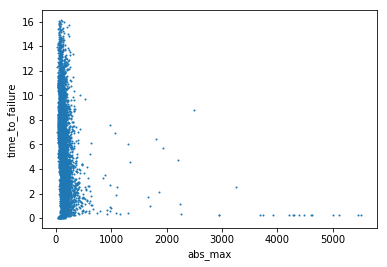

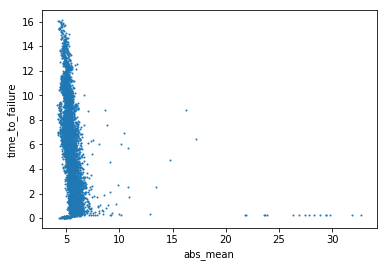

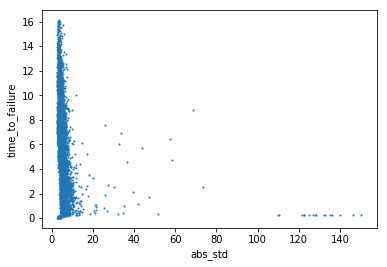

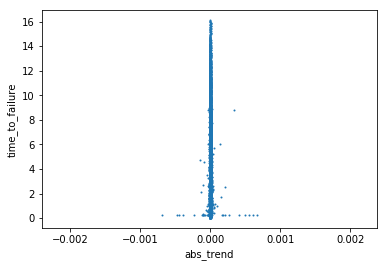

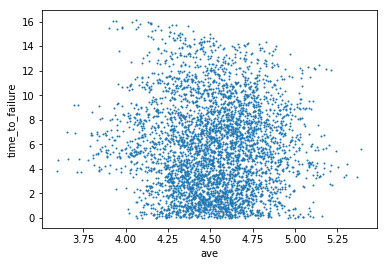

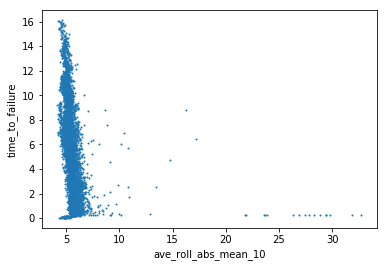

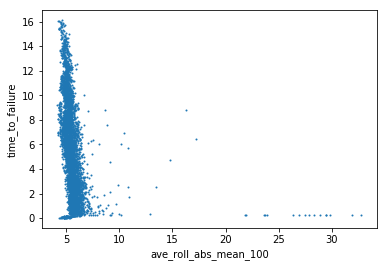

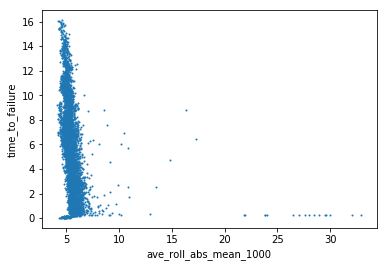

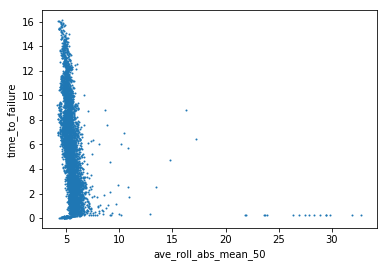

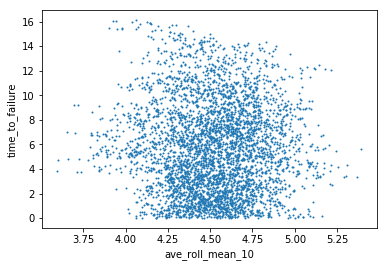

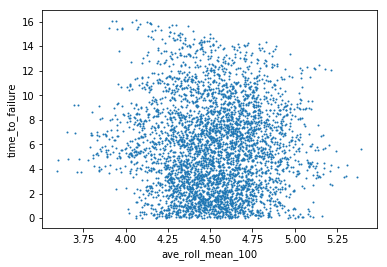

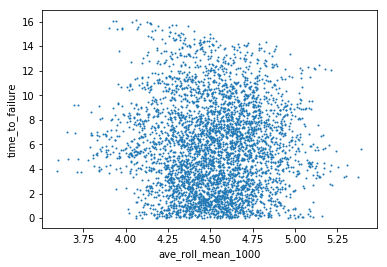

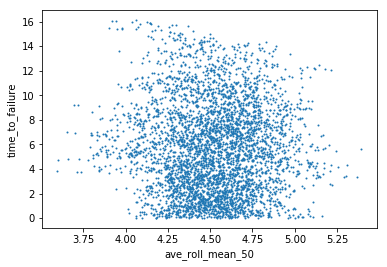

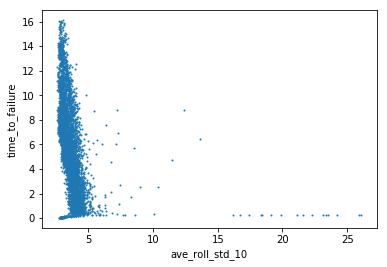

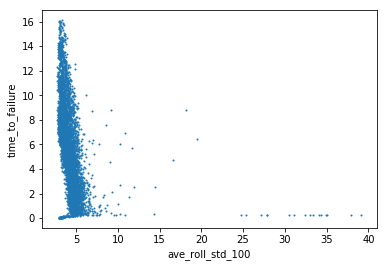

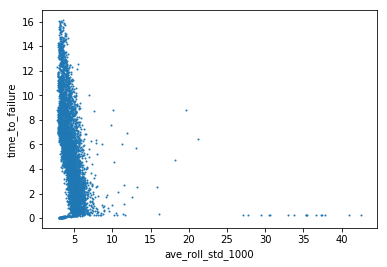

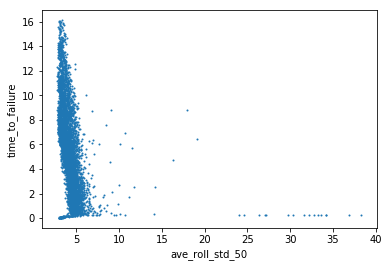

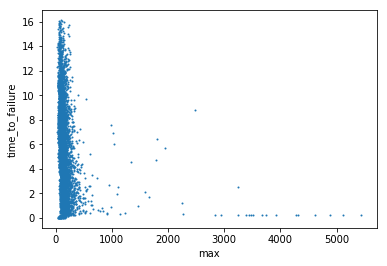

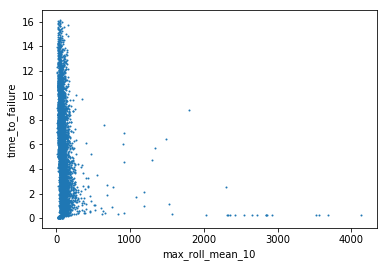

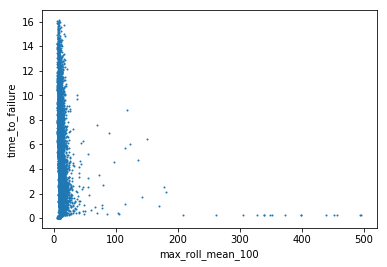

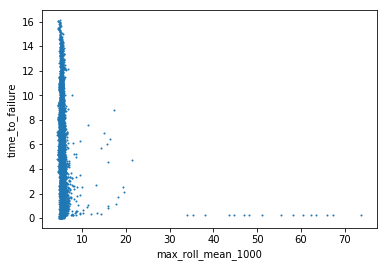

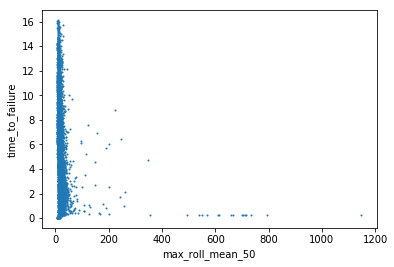

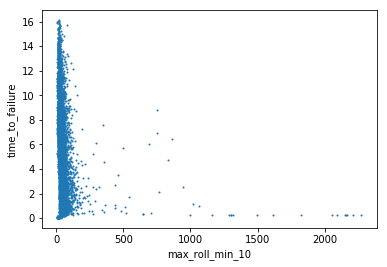

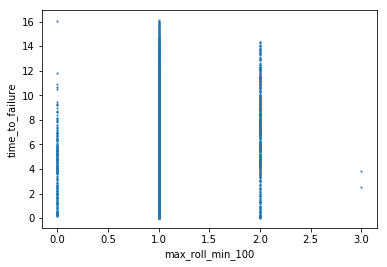

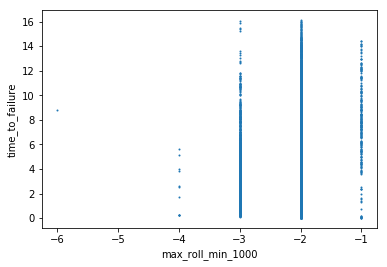

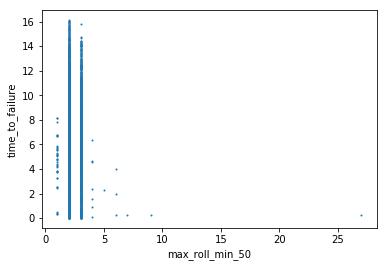

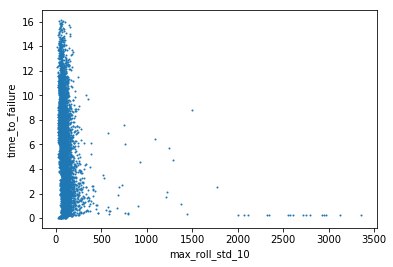

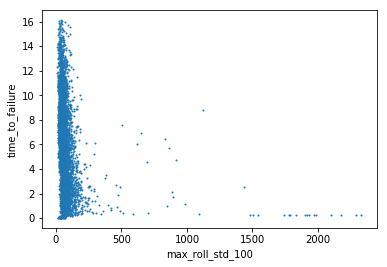

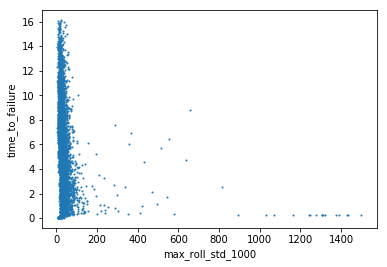

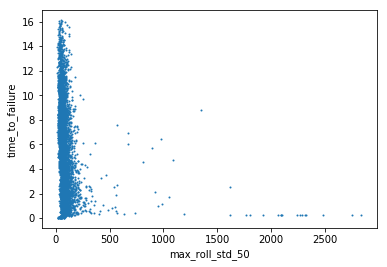

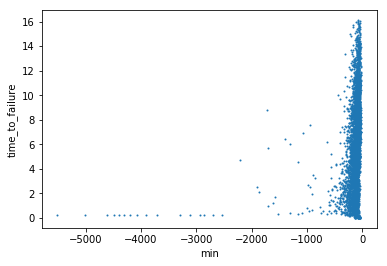

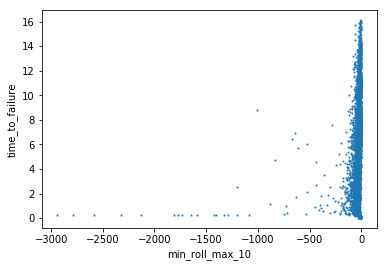

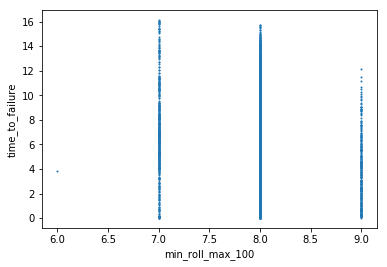

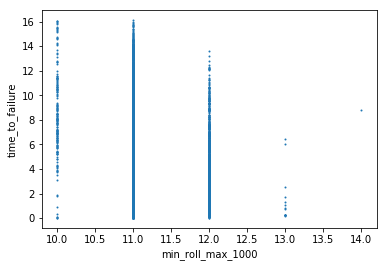

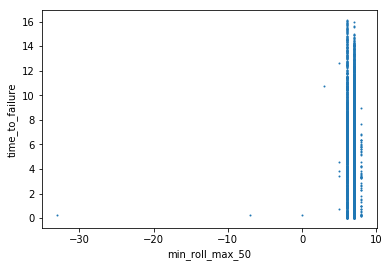

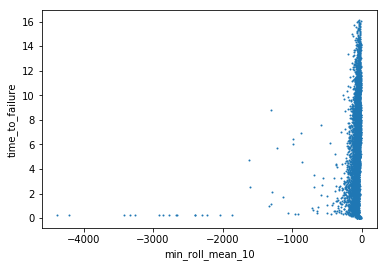

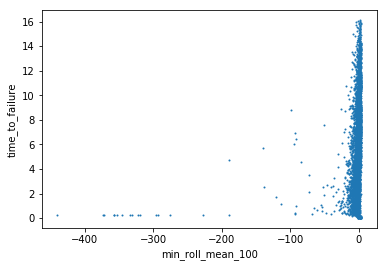

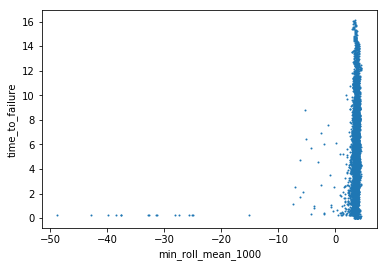

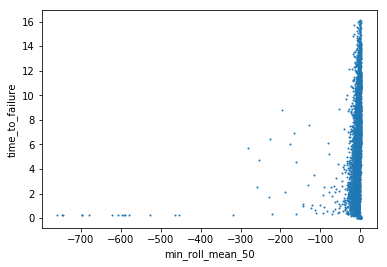

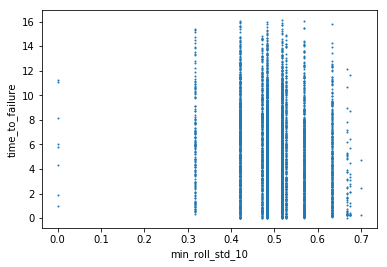

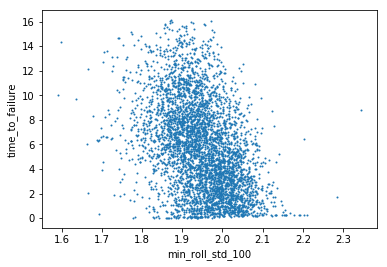

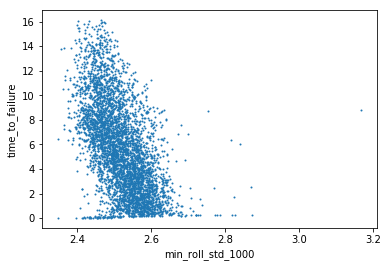

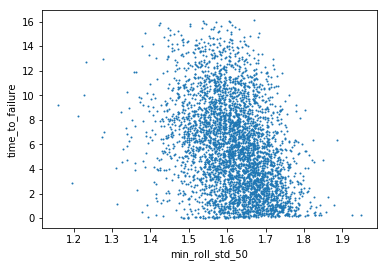

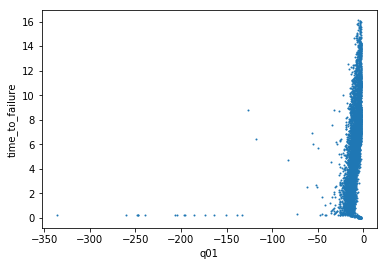

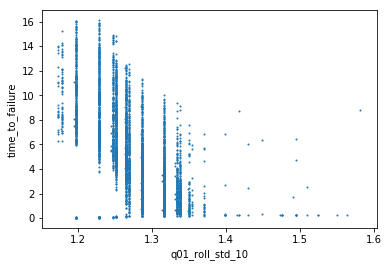

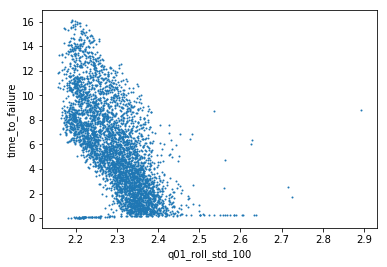

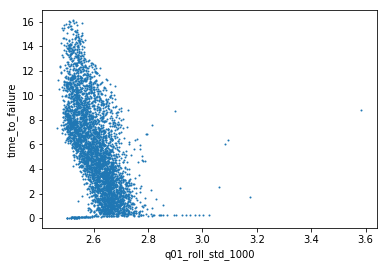

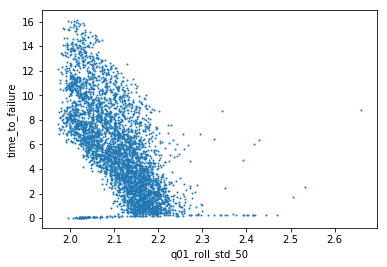

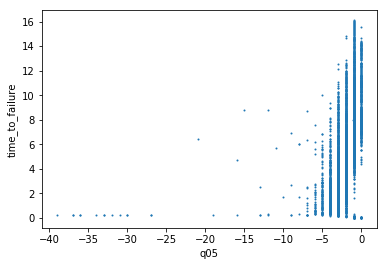

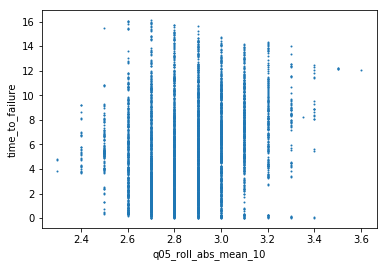

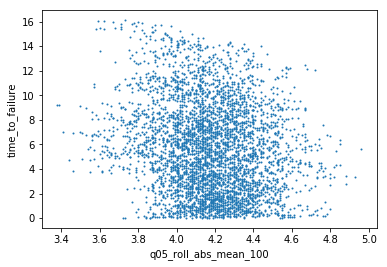

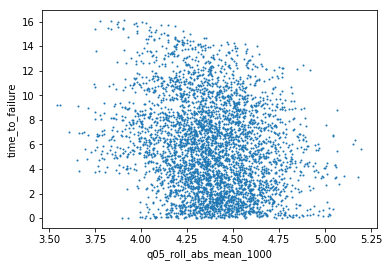

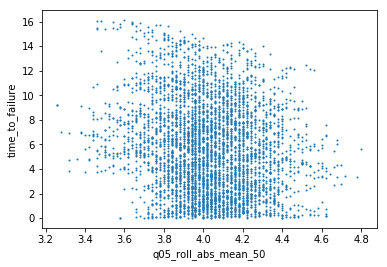

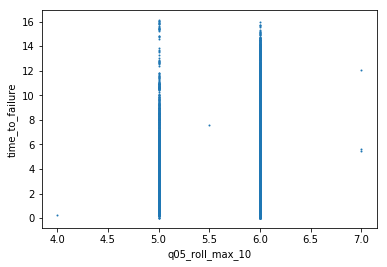

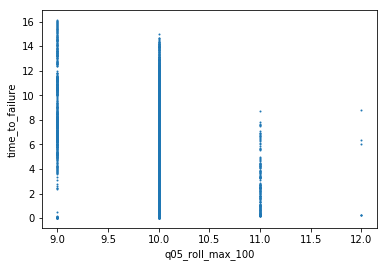

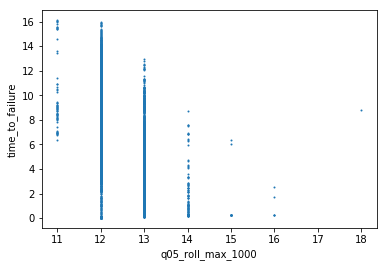

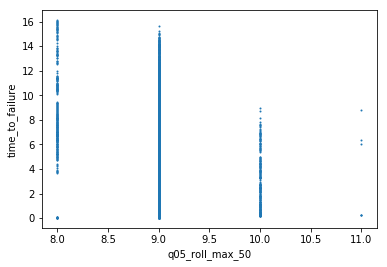

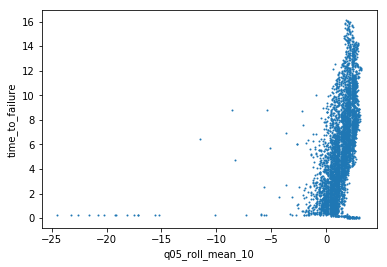

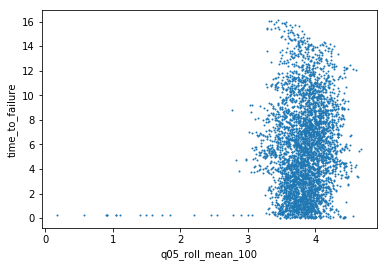

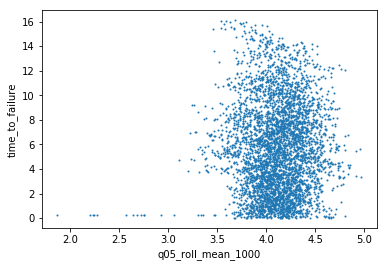

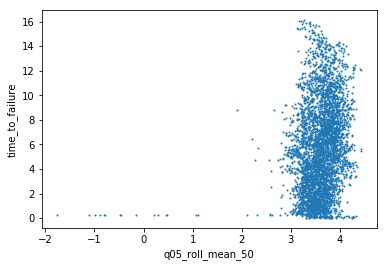

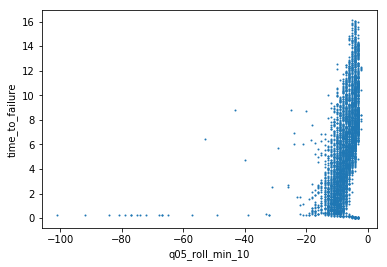

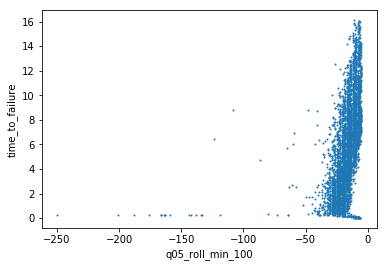

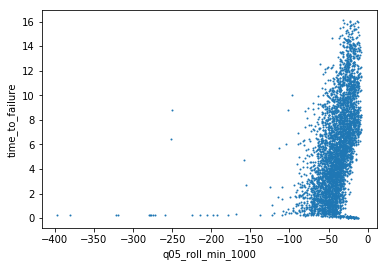

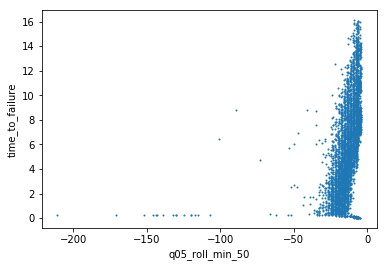

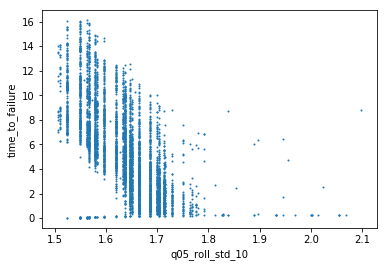

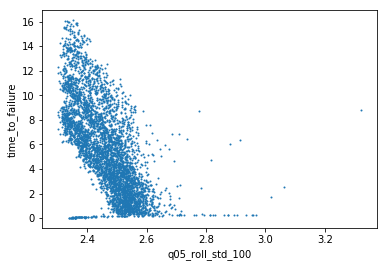

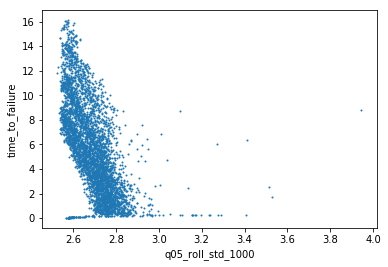

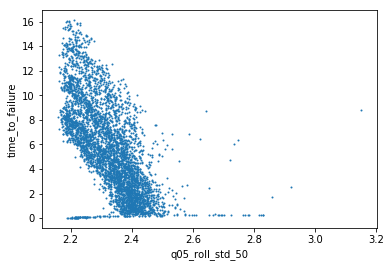

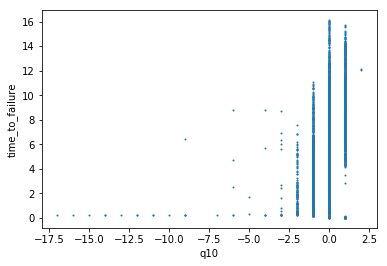

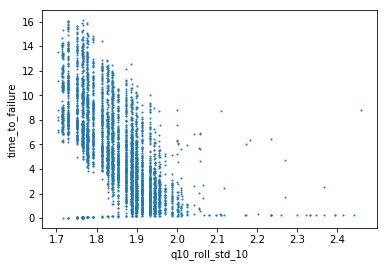

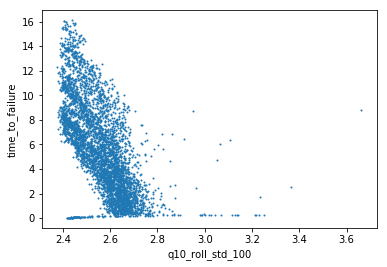

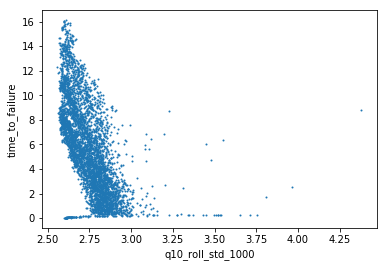

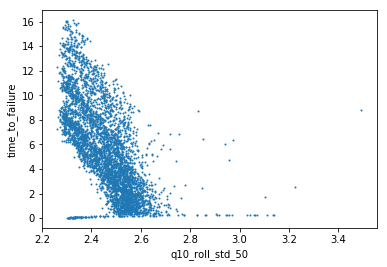

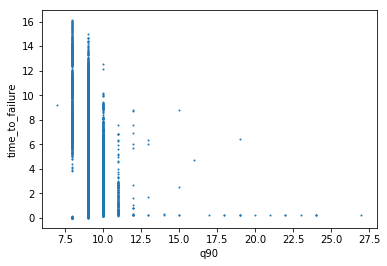

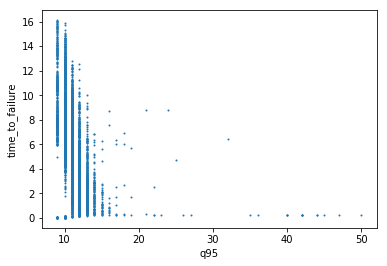

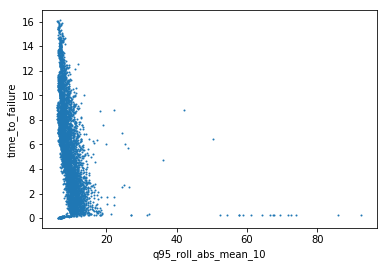

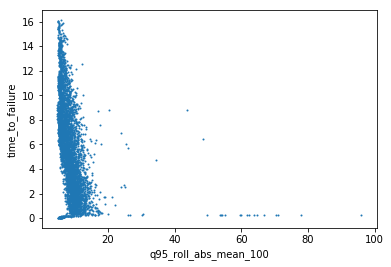

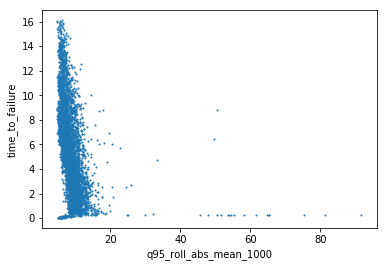

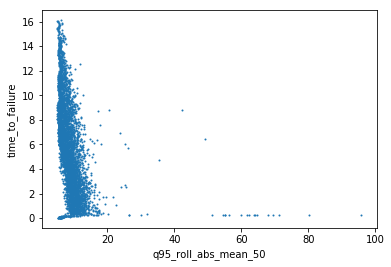

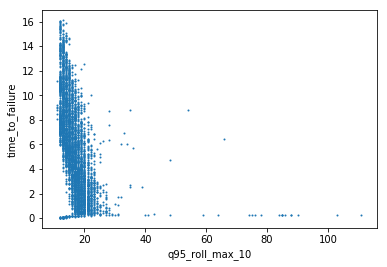

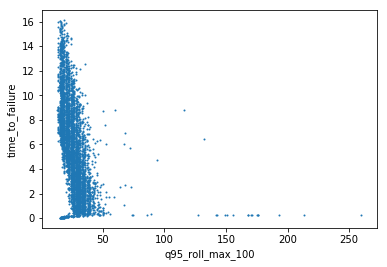

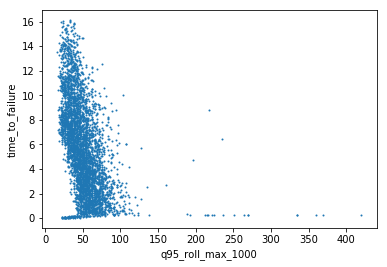

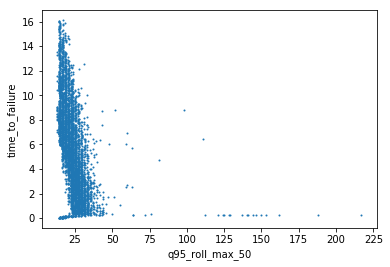

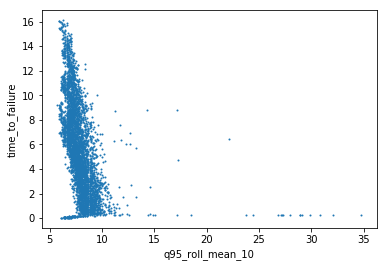

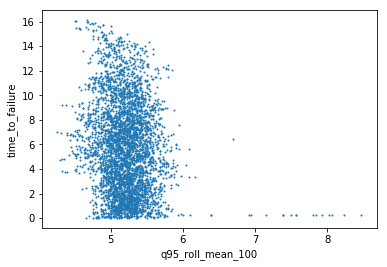

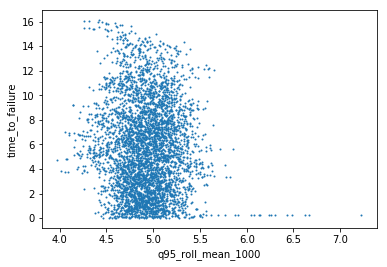

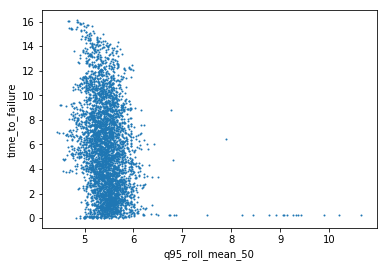

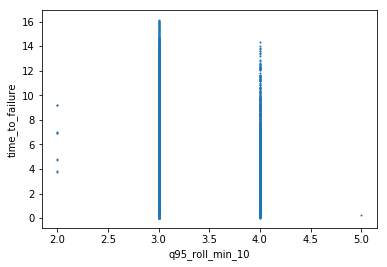

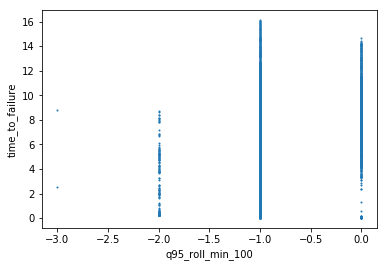

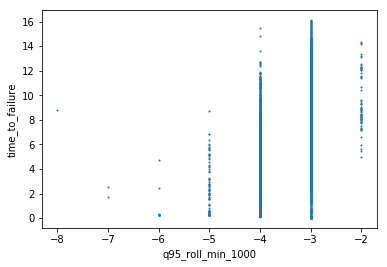

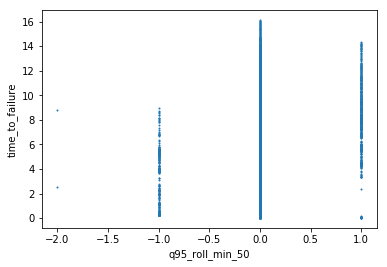

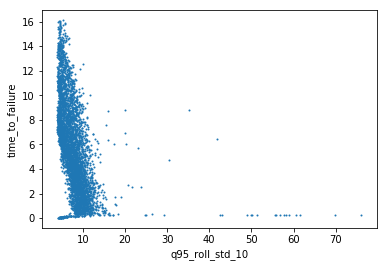

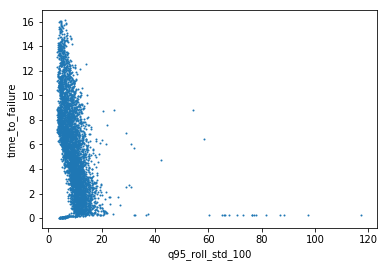

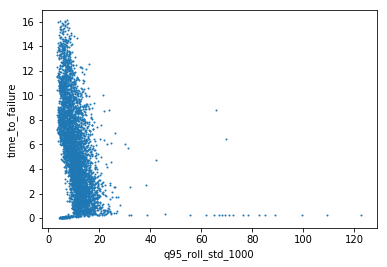

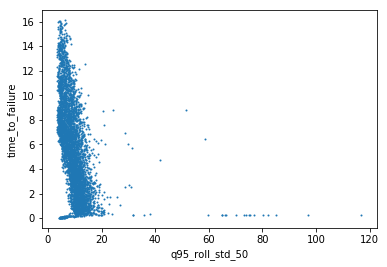

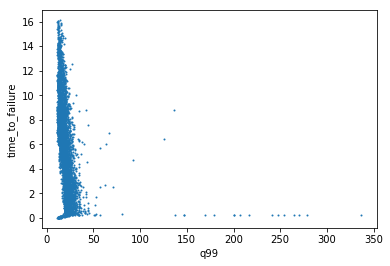

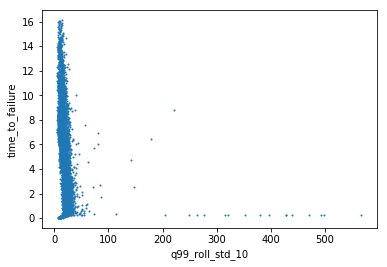

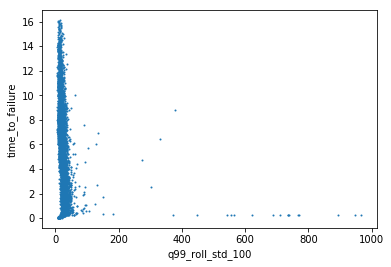

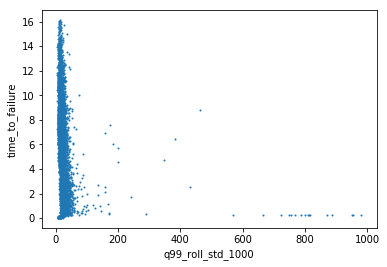

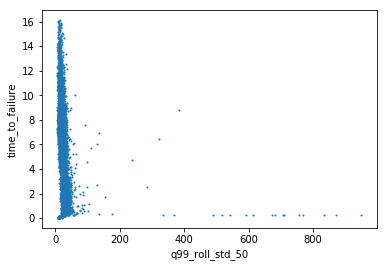

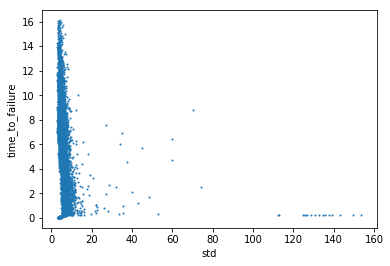

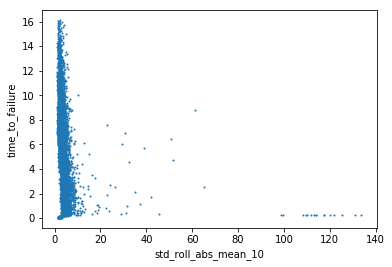

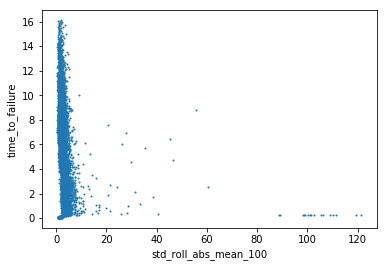

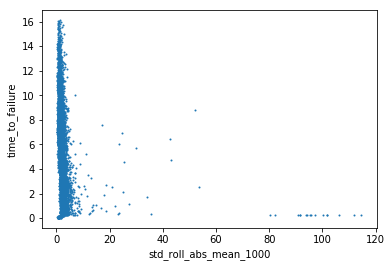

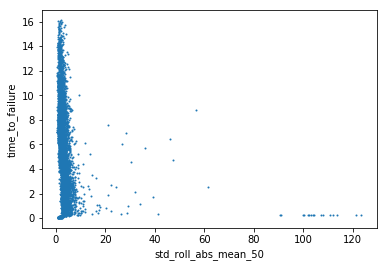

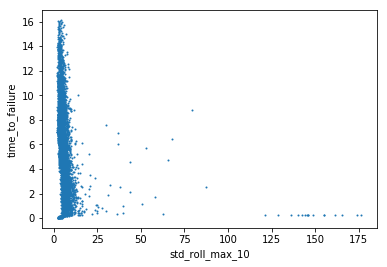

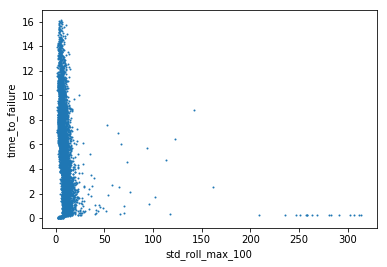

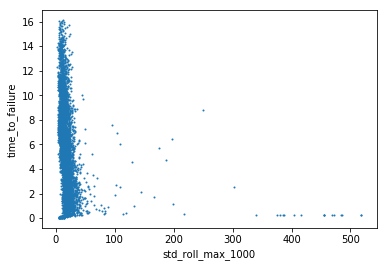

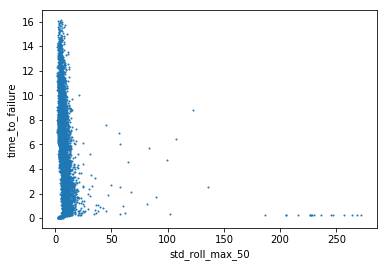

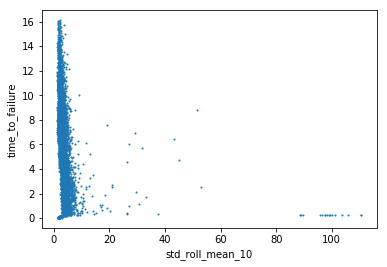

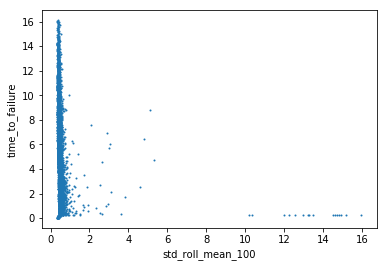

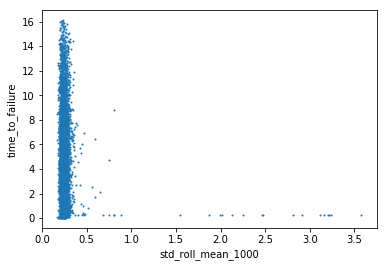

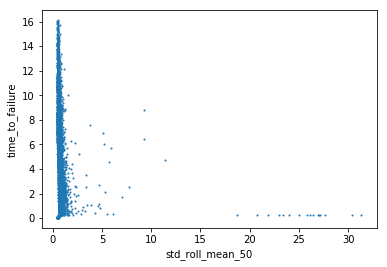

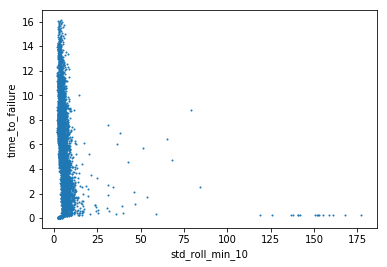

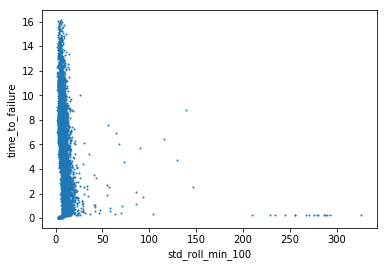

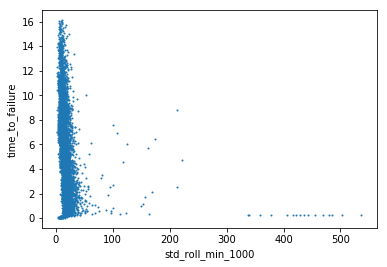

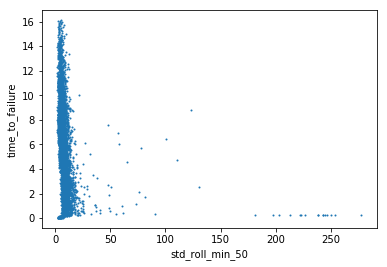

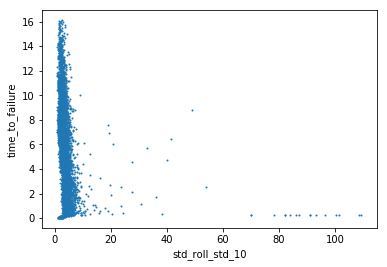

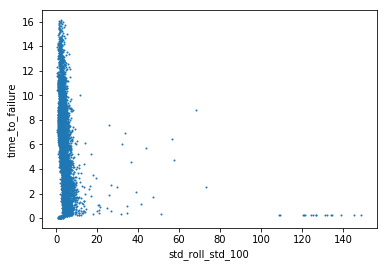

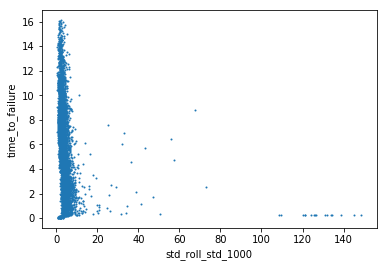

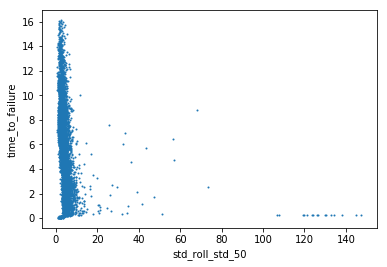

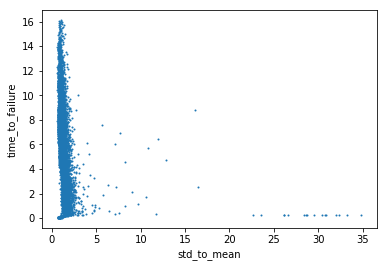

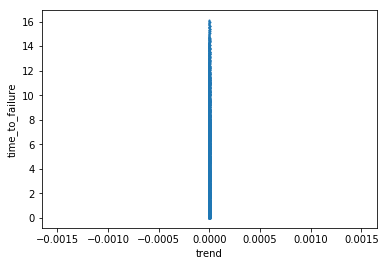

[[<matplotlib.collections.PathCollection at 0x7f97d9289c10>,
  Text(0.5,18.1063,'abs_max'),
  Text(18.1063,0.5,'time_to_failure'),
  None],
  Text(0.5,18.1063,'abs_mean'),
  Text(18.1063,0.5,'time_to_failure'),
  None],
  Text(0.5,18.1063,'abs_std'),
  Text(18.1063,0.5,'time_to_failure'),
  None],
  Text(0.5,18.1063,'abs_trend'),
  Text(18.1063,0.5,'time_to_failure'),
  None],
  Text(0.5,17.2,'ave'),
  Text(18.1063,0.5,'time_to_failure'),
  None],
  Text(0.5,18.1063,'ave_roll_abs_mean_10'),
  Text(18.1063,0.5,'time_to_failure'),
  None],
  Text(0.5,18.1063,'ave_roll_abs_mean_100'),
  Text(18.1063,0.5,'time_to_failure'),
  None],
  Text(0.5,18.1063,'ave_roll_abs_mean_1000'),
  Text(18.1063,0.5,'time_to_failure'),
  None],
  Text(0.5,18.1063,'ave_roll_abs_mean_50'),
  Text(18.1063,0.5,'time_to_failure'),
  None],
  Text(0.5,18.1063,'ave_roll_mean_10'),
  Text(18.1063,0.5,'time_to_failure'),
  None],
  Text(0.5,18.1063,'ave_roll_mean_100'),
  Text(18.1063,0.5,'time_to_failure'),
  None],


In [0]:
keys = [k for k in X]
#[[plt.scatter(X[key], Y, s=1), plt.show()] for key in ['', 'q05_roll_std_10', 'q10_roll_std_100', 'q10_roll_std_50', 'q10_roll_std_1000', 'q05_roll_std_50']]
[[ plt.scatter(X[key], Y, s=1), plt.xlabel(key), plt.ylabel('time_to_failure'),plt.show()] for i, key in enumerate(keys)]
#plt.scatter(raw_sample['acoustic_data'], raw_sample['time_to_failure'], s=1)
